In [52]:
import random
from royalur import Game
from royalur.model.player import PlayerType
from royalur.lut.board_encoder import SimpleGameStateEncoding
from huggingface_hub import hf_hub_download
from royalur import LutAgent
import os

encoding = SimpleGameStateEncoding()
REPO_ID = "sothatsit/RoyalUr"
FILENAME = "finkel.rgu"
filename = hf_hub_download(
    repo_id=REPO_ID, filename=FILENAME, cache_dir=os.getenv("HF_CACHE_DIR", None)
)
lut_player = LutAgent(filename)
lut = lut_player.lut


def lut_get_value(game_state, get_for_player):
    if game_state.is_finished():
        score_for_player = game_state.get_winner()
        value = 65535 if game_state.get_winner() == get_for_player else 0
    else:
        score_for_player = game_state.get_turn()

        # normalize turn to light for the LUT
        if game_state.get_turn() == PlayerType.DARK:
            game_state = game_state.copy_inverted()
        assert game_state.get_turn() == PlayerType.LIGHT

        value = lut.lookup(0, encoding.encode_game_state(game_state))
    if get_for_player != score_for_player:
        value = 65535 - value
    return value / 65535


def get_all_possible_moves_of_all_possible_rolls(game: Game):
    player_of_interest = game.get_turn()
    all_possible_moves_of_all_possible_rolls = {}
    for dice in range(5):
        all_possible_moves_of_all_possible_rolls[dice] = []
        game_copy = game.copy()
        game_copy.roll_dice(dice)
        if game_copy.is_waiting_for_roll():
            lut_value = lut_get_value(game_copy.get_current_state(), player_of_interest)
            # no possible moves, put score of the new state after no moves
            all_possible_moves_of_all_possible_rolls[dice].append({"score": lut_value, "dice": dice})
            continue

        for move in game_copy.find_available_moves():
            game_copy_copy = game_copy.copy()
            game_copy_copy.make_move(move)
            lut_value = lut_get_value(game_copy_copy.get_current_state(), player_of_interest)
            # Since score is for current player and the player changes after a move, invert the score of the other player
            all_possible_moves_of_all_possible_rolls[dice].append({"score": lut_value, "dice": dice})
        assert len(all_possible_moves_of_all_possible_rolls[dice]) > 0

    return all_possible_moves_of_all_possible_rolls


def compute_dice_luck_metric(rolled_dice, all_possible_moves_of_all_possible_rolls):
    # pick the best/worst possible move score in all_possible_moves_of_all_possible_rolls
    best_by_dice = {
        dice: max(all_possible_moves_of_all_possible_rolls[dice], key=lambda x: x["score"])
        for dice in all_possible_moves_of_all_possible_rolls
    }
    # pick the best of the best dice
    best_roll = max(best_by_dice.values(), key=lambda x: x["score"])
    best_score = best_roll["score"]
    # pick the worst of the best dice
    worst_roll = min(best_by_dice.values(), key=lambda x: x["score"])
    worst_score = worst_roll["score"]
    
    return (best_by_dice[rolled_dice]["score"] - worst_score) / (best_score - worst_score)


def compute_dice_luck_metric_sort(rolled_dice, all_possible_moves_of_all_possible_rolls):
    # pick the best/worst possible move score in all_possible_moves_of_all_possible_rolls
    best_by_dice = {
        dice: max(all_possible_moves_of_all_possible_rolls[dice], key=lambda x: x["score"])
        for dice in all_possible_moves_of_all_possible_rolls
    }
    
    # sort the dice by best score
    sorted_dice = sorted(best_by_dice.items(), key=lambda x: x[1]["score"], reverse=True)
    
    # determine the order that the rolled dice is in
    rolled_dice_order = [dice for dice, _ in sorted_dice].index(rolled_dice)

    # compute score, where 0 is the worst and 1 is the best
    return rolled_dice_order


def compute_move_quality_metric(game: Game, moves, picked_move):
    if len(moves) <= 1:
        return None
    player_of_interest = game.get_turn()
    move_score_map = {}
    for move in moves:
        game_copy = game.copy()
        game_copy.make_move(move)
        lut_value = lut_get_value(game_copy.get_current_state(), player_of_interest)
        move_score_map[move] = lut_value
    
    best_move = max(move_score_map.items(), key=lambda x: x[1])
    best_score = best_move[1]
    # pick the worst of the best dice
    worst_move = min(move_score_map.items(), key=lambda x: x[1])
    worst_score = worst_move[1]
    if best_score == worst_score:
        return None
    return (move_score_map[picked_move] - worst_score) / (best_score - worst_score)



def compute_move_quality_metric_sort(game: Game, moves, picked_move):
    if len(moves) <= 1:
        return None
    player_of_interest = game.get_turn()
    move_score_map = {}
    for move in moves:
        game_copy = game.copy()
        game_copy.make_move(move)
        lut_value = lut_get_value(game_copy.get_current_state(), player_of_interest)
        move_score_map[move] = lut_value
    
    # sort the moves by best score
    sorted_moves = sorted(move_score_map.items(), key=lambda x: x[1], reverse=True)

    # determine the order that the picked move is in
    picked_move_order = [move for move, _ in sorted_moves].index(picked_move)

    # compute score, where 0 is the best
    return picked_move_order


all_dark_skill_points = []
all_luck_points = []
all_light_skill_points = []

def _play_randomly(game: Game):
    light_skill_points = []
    dark_skill_points = []
    luck_points = []
    while not game.is_finished():
        if game.is_waiting_for_roll():
            all_possibilities = get_all_possible_moves_of_all_possible_rolls(game)
            #print(all_possibilities)
            roll = game.roll_dice()
            # compute dice luck metric
            dice_luck_metric = compute_dice_luck_metric_sort(roll.value, all_possibilities)
            #dice_luck_metric = compute_dice_luck_metric(roll.value, all_possibilities)
            if dice_luck_metric is not None:
                luck_points.append(dice_luck_metric)
            #print(f"Rolled: {roll.value}, dice luck metric: {dice_luck_metric}")
        else:
            player = game.get_turn()
            moves = game.find_available_moves()
            if player == PlayerType.LIGHT:
                move = lut_player.play(game)
            else:
                move = moves[random.randint(0, len(moves) - 1)]
            skill_metric = compute_move_quality_metric_sort(game, moves, move)
            #skill_metric = compute_move_quality_metric(game, moves, move)
            if skill_metric is not None:
                if player == PlayerType.LIGHT:
                    light_skill_points.append(skill_metric)
                else:
                    dark_skill_points.append(skill_metric)
            #print(skill_metric)
            # compute move quality metric
            game.make_move(move)

    all_dark_skill_points.extend(dark_skill_points)
    all_light_skill_points.extend(light_skill_points)
    all_luck_points.extend(luck_points)


In [53]:
from embarrassing import embarrassing

embarrassing(range(100), lambda x: _play_randomly(Game.create_finkel()))

100%|██████████| 100/100 [00:20<00:00,  4.84it/s]


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [56]:
import pandas as pd

dark_skill_series = pd.Series(all_dark_skill_points)
luck_series = pd.Series(all_luck_points)
light_skill_series = pd.Series(all_light_skill_points)

<Axes: >

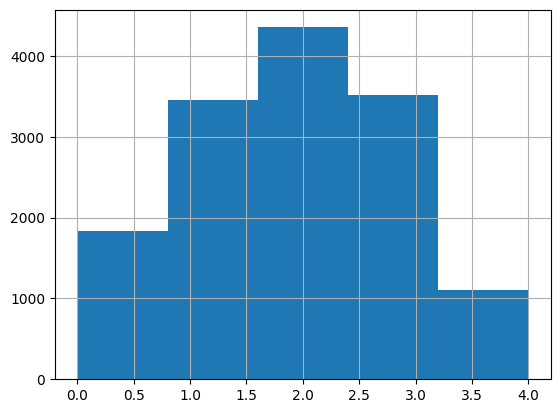

In [58]:
luck_series.hist(bins=5)

<Axes: >

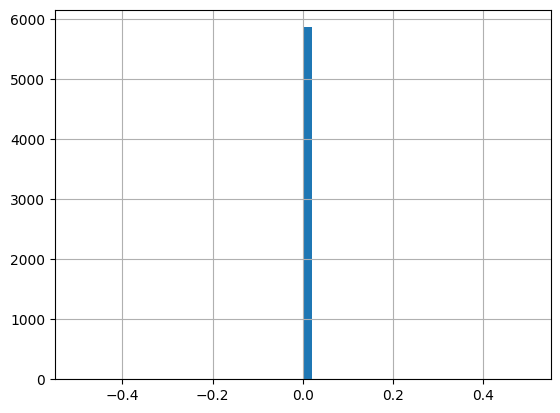

In [59]:
light_skill_series.hist(bins=50)

<Axes: >

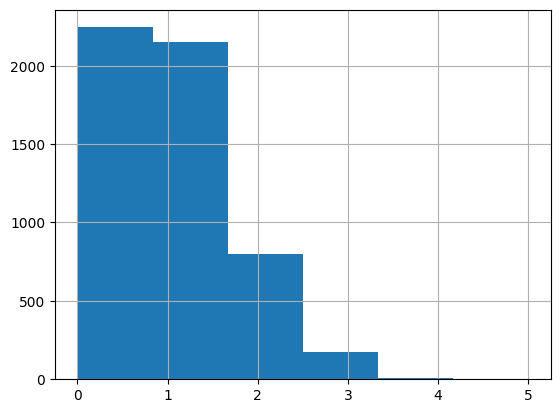

In [61]:
dark_skill_series.hist(bins=6)

In [62]:
dark_skill_series.mean(), luck_series.mean(), light_skill_series.mean()

(0.8022693452380952, 1.9019924231794585, 0.0)